In [1]:
import pandas as pd
import numpy as np
import requests
import json
from scipy import stats

# 1. Cargar los datos directamente del json
df = pd.read_json('data\churn_future.json')
data_json = json.loads(df.to_json(orient='records'))

# 2. Enviar solicitudes a los endpoints. El modelo base será knn_model y el mejor modelo será rf_model
endpoints = ["http://127.0.0.1:5000/knn_model/predict", "http://127.0.0.1:5000/rf_model/predict"]

# Distribución de las Probabilidades:
Recopilamos las probabilidades de que un cliente se clasifique como churn (prob_si) para cada modelo (KNN y RF) a lo largo de la ventana de tiempo de 7 días.
Estas probabilidades se almacenan en las listas knn_probs y rf_probs.

In [2]:
results = {day: [] for day in range(7)}

for record in data_json:
    day = np.random.choice(range(7))  # Asignar un día aleatoriamente
    endpoint = np.random.choice(endpoints)  # Seleccionar un endpoint de manera aleatoria
    response = requests.post(endpoint, json=[record])
    results[day].append({'model': 'KNN' if 'knn' in endpoint else 'RF', 
                         'response': response.json(), "real_label": record['Churn']})

# 3. Análisis de los resultados
# a. Comparar las distribuciones de las probabilidades
knn_probs = [r['response'][0]['prob_si'] for day in results for r in results[day] if r['model'] == 'KNN']
rf_probs = [r['response'][0]['prob_si'] for day in results for r in results[day] if r['model'] == 'RF']

# Evaluación de la Normalidad:

Asumimos que las distribuciones tienen un comportamiento normal. Aunque no realizamos un test de normalidad (como el test de Shapiro-Wilk). Esta asunción es una suposición común para aplicar pruebas T

# Prueba T de Student para Comparar Medias:

la función ***stats.ttest_ind*** permite realizar una prueba T de dos muestras independientes. Esto compara las medias de las distribuciones de probabilidad de churn para los dos modelos.

El resultado de la prueba T se da en términos de un valor t (t_stat) y un valor p (p_value).

In [3]:
# Prueba t para comparar medias
t_stat, p_value = stats.ttest_ind(knn_probs, rf_probs)
print("T-test: t_stat = {}, p_value = {}".format(t_stat, p_value))

T-test: t_stat = -1.9875545323980988, p_value = 0.04713393163105368


- Un t_stat de -1.9875 indica que la diferencia entre las medias de las probabilidades de churn de ambos modelos empieza a notarse. Además el valor negativo indica que la media de las probabilidades de churn en knn es menor que en rf.

- Bajo la hipótesis de que no hay diferencia real entre los grupos (hipótesis nula). El p_value de 0.0471 está por debajo a del umbral común de 0.05. Esto significa que SI hay una diferencia significativa entre las predicciones de los modelos.

# ¿Cómo se distribuyen las probabilidades entre los dos grupos?

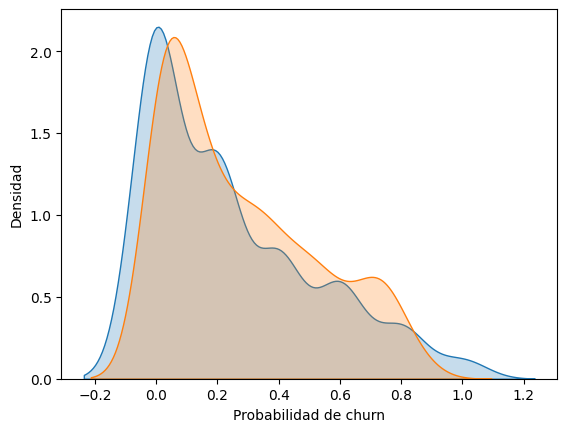

In [4]:
# Visualizar la distribución de las probabilidades de churn para knn_probs y rf_probs
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(knn_probs, fill=True, label='KNN')
sns.kdeplot(rf_probs, fill=True, label='RF')
plt.xlabel('Probabilidad de churn')
plt.ylabel('Densidad')
plt.show()

Como podemos ver, no hay una diferencia notoria notoria entre las distribuciones, aunque para las probabilidades entre 0.3 y 0.8 hay una mayor densidad por parte de random forest.

# ¿Son significativas las diferencias entre las probabilidades de ambos modelos?

Sabiendo que el valor del p_value (0.1328) es mayor a 0.05 podemos decir que no hay suficiente evidencia para afirmar que las diferencias en las predicciones de churn entre los modelos son significativas.

# Cálculo de la Predicción Diaria de Churn:
Procedemos a calcular las predicciones diarias de churn para cada modelo. Para el mejor modelo (RF), obtenemos una lista de porcentajes de predichos para cada uno de los 7 días.

In [5]:
daily_churn_predictions = {'KNN': [0]*7, 'RF': [0]*7}
daily_counts = {'KNN': [0]*7, 'RF': [0]*7}

for day in results:
    for result in results[day]:
        model = result['model']
        daily_churn_predictions[model][day] += (1 if result['response'][0]['label'] == 'Yes' else 0)
        daily_counts[model][day] += 1

# Calcular el promedio diario de predicciones de churn para cada modelo
daily_avg_churn_KNN = [churn/count if count > 0 else 0 for churn, count in zip(daily_churn_predictions['KNN'], daily_counts['KNN'])]
daily_avg_churn_rf = [churn/count if count > 0 else 0 for churn, count in zip(daily_churn_predictions['RF'], daily_counts['RF'])]

# Cálculo del Incremento/Decremento Porcentual

Como baseline, utilizaremos el promedio de las predicciones de churn del modelo KNN a lo largo de la ventana de tiempo.

Para cada día, calculamos el incremento o decremento porcentual en las predicciones de churn del modelo RF en comparación con el baseline (KNN). Esto se hace restando el baseline del porcentaje de churn predicho por el RF y luego dividiendo el resultado por el baseline, multiplicado por 100 para obtener un porcentaje.

In [6]:
print(daily_avg_churn_rf)
print(daily_avg_churn_KNN)

[0.15584415584415584, 0.24242424242424243, 0.21052631578947367, 0.19402985074626866, 0.2, 0.1951219512195122, 0.29411764705882354]
[0.22580645161290322, 0.140625, 0.1774193548387097, 0.24675324675324675, 0.20481927710843373, 0.208955223880597, 0.14102564102564102]


In [7]:
# RF es el mejor modelo según los resultados anteriores
# Baseline usando el promedio diario de KNN como referencia
daily_percentage_changes = [(rf - KNN) / KNN * 100 if KNN > 0 else 0 for rf, KNN in zip(daily_avg_churn_rf, daily_avg_churn_KNN)]

print("Incremento/decremento porcentual diario respecto al baseline:", daily_percentage_changes)

Incremento/decremento porcentual diario respecto al baseline: [-30.983302411873844, 72.39057239057239, 18.6602870813397, -21.3668499607227, -2.3529411764705794, -6.620209059233442, 108.55614973262033]


# ¿Cuál fue el incremento o decremento porcentual diario de predicción de casos de churn que tuvo el mejor modelo (punto 3) respecto al baseline (punto 2)?

Día 1: -30.98%,
Día 2:  72.39%,
Día 3: 18.66%,
Día 4: -21.36%,
Día 5: -2.35%,
Día 6: -6.62%,
Día 7: 108.55%,

- Variabilidad Diaria: Los resultados muestran una variabilidad significativa en el desempeño relativo de los dos modelos de un día para otro. Esto puede deberse a diferencias en las características de los datos de entrada para cada día.
- Predominio de Incrementos: A en los días 1,4,5,6, se observó que el número de casos de churn predichos por el modelo RF fue menor que el número de casos de churn predichos por el modelo KNN. En los demás días, el modelo RF predijo un mayor número de casos de churn en comparación con el modelo KNN. El día 7 en particular nos muestra un incremento de 108.55% por lo que en general, esto sugiere que el modelo RF tiene una tendencia a predecir más casos de churn que el modelo KNN.

- Días con Mayor Variación: Los días 1 y 7 muestran los cambios más significativos. En donde el modelo de RF tuvo un decremento porcentual de -30.98% y 108.55% respectivamente. El segundo valor es especialmente alto.

#  ¿cuál fue el porcentaje de éxito del modelo prediciendocasos de efectivos de churn?


In [8]:
# c. Calcular el porcentaje de éxito del modelo
daily_accuracy = []

for day in results:
    correct_predictions = 0
    for result in results[day]:
        if result['real_label'] == result['response'][0]['label']:
            correct_predictions += 1
    daily_accuracy.append(correct_predictions / len(results[day]))

print("Precisión diaria del modelo:", daily_accuracy)

Precisión diaria del modelo: [0.7841726618705036, 0.7615384615384615, 0.773109243697479, 0.7708333333333334, 0.8092485549132948, 0.785234899328859, 0.7876712328767124]


Día 1: Precisión del 78.41%,
Día 2: Precisión del 76.15%,
Día 3: Precisión del 77.31%,
Día 4: Precisión del 77.08%,
Día 5: Precisión del 80.92%,
Día 6: Precisión del 78.52%,
Día 7: Precisión del 78.76%,

- Alto Nivel de Precisión: En todos los días, el modelo muestra una precisión superior al 75%, lo cual es generalmente considerado un buen resultado en muchas aplicaciones. Esto indica que el modelo es efectivo en la identificación de casos de churn.
- Variabilidad Diaria: Se observa cierta variabilidad en la precisión de un día para otro, aunque esta no llega a superar el 4%. Estas pequeñas diferencias pueden ser causado por diferencias en los patrones de los datos diarios o por la variabilidad inherente en el modelo o en el proceso de predicción.